In [1]:
import torch
dataset_type = "CIFAR10"
sample_2D = False
sample_208D = False
save_origin_pic = False

device = torch.device("cuda:1")

#### vae模型以及自定义datasets

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import sys
python_files_dir = "./python_files/" # python工具包位置
sys.path.append(python_files_dir)
import my_tools
import fid_score as official_fid

model_files_dir = "./model_files/" # 模型位置
sys.path.append(model_files_dir)
import model_files as all_model

from CIFAR10.models import ResNet20 as classify_model
from CIFAR10.models import Rob_predictor as my_Rob_predictor
from CIFAR10.models import BigGAN

from tqdm import tqdm
import numpy as np
import random
import torchvision.utils as utils

import datetime
# 定义VAE模型
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()

        self.latent_dim = latent_dim

        # 编码器
        self.encoder = nn.Sequential(
            nn.Linear(208, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)

        # 解码器
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 208),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z
    
    def get_2D(self, x):
        mu, logvar = self.encode(x.view(-1, 208))
        z = self.reparameterize(mu, logvar)
        return z

    def decode(self, z):
        x = self.decoder(z)
        return x

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 208))
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar

# 自定义datasets
class Mydata_sets(Dataset):
    def __init__(self, path, device, transform=None):
        super(Mydata_sets, self).__init__()
        self.latent_z = torch.load(path, map_location=device)

    def __getitem__(self, index):
        z = self.latent_z[index].detach()
        return z

    def __len__(self):
        return len(self.latent_z)

# 插值函数
def get_zs_prevent_stick(coordinates, kdTree_2D, latent_z, k=50):
    '''
    nearest_distance: n*k维
    nearest_index: n*k维
    dict_zs: 键是文件的id号, 值是对应的z（后面直接改成数组了，问题不大）
    '''
    print("进入了防止粘在一块~~~~~~~~~~~~~~~~~~")
    # 直接一次查询所有坐标的k个近邻
    nearest_distance, nearest_index = kdTree_2D.query(coordinates, k=k)
    origin_coordinates = kdTree_2D.data # 获取kdtree中原始的坐标
    for i, pos in enumerate(coordinates): #对每一个坐标进行插值
        # pos坐标对应的近邻下标
        pos_nearst_index = nearest_index[i] # 其中有k个index，每个index对应kdTree_2D中的一个2维坐标
        pos_nearst_distance = nearest_distance[i]

        # 最近邻的坐标点，以及最近的距离
        most_nearst_pos = origin_coordinates[pos_nearst_index[0]]
        most_nearst_dis = pos_nearst_distance[0]

        # 利用三角形,找到第二个插值基点，让两边之和越接近第三边，就越是钝角，就越合理
        s1 = most_nearst_dis
        best_index = 1 # 默认第二个最近邻最好
        min_dif = 100
        for j in range(1, k):
            cur_pos = origin_coordinates[pos_nearst_index[j]]
            s2 = pos_nearst_distance[j]
            s3 = np.linalg.norm(most_nearst_pos-cur_pos)
            if (s1 + s2) - s3 < min_dif: # 两边之和大于等于第三边，所以不用绝对值
                min_dif = (s1 + s2) - s3
                best_index = j
        
        temp_z_0 = latent_z[pos_nearst_index[0]].clone().detach()
        temp_z_1 = latent_z[pos_nearst_index[best_index]].clone().detach()
        sum_distance = most_nearst_dis + pos_nearst_distance[best_index]
        z_new = (sum_distance-most_nearst_dis)/(sum_distance) * temp_z_0 + (sum_distance-pos_nearst_distance[best_index])/(sum_distance) * temp_z_1

        z_new = z_new.unsqueeze(0)
        if i == 0:
            zs = z_new
        else:
            zs = torch.cat((zs, z_new), dim=0)

    return zs


# 插值函数，不对类向量进行插值，类取最近的那一个点
def get_zs_prevent_stick_not_class(coordinates, kdTree_2D, latent_z, k=20):
    '''
    nearest_distance: n*k维
    nearest_index: n*k维
    dict_zs: 键是文件的id号, 值是对应的z（后面直接改成数组了，问题不大）
    '''
    print("进入了防止粘在一块，并且不对控制类别的向量进行插值~~~~~~~~~~~~~~~~~~")
    # 直接一次查询所有坐标的k个近邻
    nearest_distance, nearest_index = kdTree_2D.query(coordinates, k=k)
    origin_coordinates = kdTree_2D.data # 获取kdtree中原始的坐标
    for i, pos in enumerate(coordinates): #对每一个坐标进行插值
        # pos坐标对应的近邻下标
        pos_nearst_index = nearest_index[i] # 其中有k个index，每个index对应kdTree_2D中的一个2维坐标
        pos_nearst_distance = nearest_distance[i]

        # 最近邻的坐标点，以及最近的距离
        most_nearst_pos = origin_coordinates[pos_nearst_index[0]]
        most_nearst_dis = pos_nearst_distance[0]

        # 利用三角形,找到第二个插值基点，让两边之和越接近第三边，就越是钝角，就越合理
        s1 = most_nearst_dis
        best_index = 1 # 默认第二个最近邻最好
        min_dif = 100
        for j in range(1, k):
            cur_pos = origin_coordinates[pos_nearst_index[j]]
            s2 = pos_nearst_distance[j]
            s3 = np.linalg.norm(most_nearst_pos-cur_pos)
            if (s1 + s2) - s3 < min_dif: # 两边之和大于等于第三边，所以不用绝对值
                min_dif = (s1 + s2) - s3
                best_index = j
        
        temp_z_0 = latent_z[pos_nearst_index[0]].clone().detach()
        temp_z_1 = latent_z[pos_nearst_index[best_index]].clone().detach()
        sum_distance = most_nearst_dis + pos_nearst_distance[best_index]
        z_new = (sum_distance-most_nearst_dis)/(sum_distance) * temp_z_0 + (sum_distance-pos_nearst_distance[best_index])/(sum_distance) * temp_z_1

        z_new[-128:] = temp_z_0[-128:] # 不修改类标签

        z_new = z_new.unsqueeze(0)
        if i == 0:
            zs = z_new
        else:
            zs = torch.cat((zs, z_new), dim=0)

    return zs



    # 最开始的版本，优化了一下代码


# 最开始的版本，就取近邻的向量进行插值
def get_zs_new(coordinates, kdTree_2D, latent_z, k=20):
    '''
    coordinates: n个要插值的坐标
    kdTree_2D: 降维后的2D坐标
    latent_z: 生成模型的输入潜向量，和kdTree_2D是一一对应关系
    k: 近邻的数量
    '''
    print("最开始的版本，优化了一下代码~~~~~~~~~~~ k:",k)
    # 直接一次查询所有坐标的k个近邻
    nearest_distance, nearest_index = kdTree_2D.query(coordinates, k=k) #这里的k为固定值
    origin_coordinates = kdTree_2D.data # 获取kdtree中原始的坐标
    for iter in range(len(coordinates)):
        iter_distance = nearest_distance[iter]
        iter_index = nearest_index[iter]
        
        sum_distanceForIter = np.sum(iter_distance) #这k个近邻的距离总和
        for i, index in enumerate(iter_index):
            temp_z = torch.tensor(latent_z[index])
            temp_distance = iter_distance[i]
            w = (sum_distanceForIter-temp_distance)/((k-1)*sum_distanceForIter) #对z进行权重
            if i == 0:
                z = temp_z*w
            else:
                z += temp_z*w
        z = z.unsqueeze(0) # shape:[1*latent_dim]
        if iter == 0:
            zs = z
        else:
            zs = torch.cat((zs, z), dim=0)
        # print(zs.shape)
    return zs


# 最开始的版本，就取近邻的向量进行插值，但是不对类的向量进行插值
def get_zs_new_not_class(coordinates, kdTree_2D, latent_z, k=50000):
    '''
    coordinates: n个要插值的坐标
    kdTree_2D: 降维后的2D坐标
    latent_z: 生成模型的输入潜向量，和kdTree_2D是一一对应关系
    k: 近邻的数量
    '''
    print("最开始的版本，优化了一下代码~~~~~~~~~~~ k:",k)
    # 直接一次查询所有坐标的k个近邻
    nearest_distance, nearest_index = kdTree_2D.query(coordinates, k=k) #这里的k为固定值
    origin_coordinates = kdTree_2D.data # 获取kdtree中原始的坐标
    for iter in range(len(coordinates)):
        iter_distance = nearest_distance[iter]
        iter_index = nearest_index[iter]
        
        sum_distanceForIter = np.sum(iter_distance) #这k个近邻的距离总和
        for i, index in enumerate(iter_index):
            temp_z = torch.tensor(latent_z[index])
            temp_distance = iter_distance[i]
            w = (sum_distanceForIter-temp_distance)/((k-1)*sum_distanceForIter) #对z进行权重
            if i == 0:
                z = temp_z*w
            else:
                z += temp_z*w

        z[-128:] = latent_z[iter_index[0]][-128:]   #类向量为最近的那一个点的向量

        z = z.unsqueeze(0) # shape:[1*latent_dim]
        if iter == 0:
            zs = z
        else:
            zs = torch.cat((zs, z), dim=0)
        # print(zs.shape)
    return zs


# 以5万个点作为基进行随机插值
def get_zs_50000_basic(coordinates, kdTree_2D, latent_z):
    # 找到最近邻，让类别是最近邻
    nearest_distance, nearest_index = kdTree_2D.query(coordinates, k=1)
    for i in range(50000):

        weights = np.random.rand(50000, 1)  # 为每个向量生成随机权重
        weights = torch.tensor(weights)
        # weights = weights.to(device)

        weighted_sum = latent_z * weights
        z = weighted_sum / torch.sum(weights)

        z[:-128] = latent_z[nearest_index[i]][-128:]
        if i == 0:
            zs = z
        else:
            zs = torch.cat((zs, z))
        
        if i == 5000:
            print("I :", i)

#### 读取vae的名字以及相关数据

In [3]:
import os 
path = "./临时垃圾-随时可删/20230814vae训练"
vae_list = os.listdir(path)
# 加载数据集
datasets = Mydata_sets('./static/data/CIFAR10/latent_z/BigGAN_random_50k_png_208z_50000.pt', device = device)
dataLoader = DataLoader(datasets, batch_size=32, shuffle=True)

#### 循环遍历每一个

######当前vae######
 vae_state_dict_epoch = 100 kl = 0.015 cl_w = 1.2 loss = 0.028671982766389846 loss_fn=official 2023-08-17 19:07:10.pt
z_2ds.shape:  torch.Size([50000, 2])


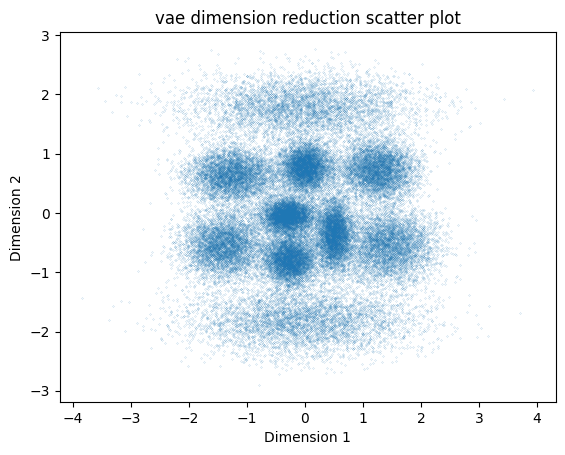

50000
生成模型加载成功！
正在生成图片。。。。


TypeError: object of type 'NoneType' has no len()

In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt


import torchvision.transforms as transforms
from torch.utils.data import Dataset
from PIL import Image 
from scipy import spatial

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.utils as utils
import numpy as np
from scipy.stats import norm
import torch


# 用来处理zs的类，方便使用batchsize
class My_z_datasets(Dataset):
    
    def __init__(self, zs):
        super(My_z_datasets, self).__init__()
        self.zs = zs

    def __getitem__(self, index):
        z = self.zs[index]
        return z

    def __len__(self):
        return len(self.zs)

class My_pic_datasets(Dataset):
    
    def __init__(self, path, transform=None):
        super(My_pic_datasets, self).__init__()
        self.root_dir = path
        self.img_names = os.listdir(self.root_dir)
        self.transform = transform

    def __getitem__(self, index):
        img_name = self.img_names[index]
        img = Image.open(os.path.join(self.root_dir, img_name))
        id_name = torch.tensor(int(img_name[4:-4])) #pic_xx.jpg
        if self.transform is not None:
            img = self.transform(img)
        return img, id_name

    def __len__(self):
        return len(self.img_names)

for vae_name in vae_list:
    plt.clf()
    if not "vae_state_dict_epoch = 100 kl = 0.015 cl_w = 1.2 loss = 0.028671982766389846 loss_fn=official 2023-08-17 19:07:10.pt" in vae_name:
        continue
    print("######当前vae######\n", vae_name)
    vae_path = os.path.join(path, vae_name)
    # 初始化VAE模型
    vae = VAE(2)
    vae.load_state_dict(torch.load(vae_path, map_location=device))
    vae = vae.to(device)
    vae.eval()

    with torch.no_grad():
        for i, data in enumerate(dataLoader):
            data = data.to(device)
            if i == 0:
                z_2ds = vae.get_2D(data)
            else:
                z_2d = vae.get_2D(data)
                z_2ds = torch.cat((z_2ds, z_2d))
    print("z_2ds.shape: ", z_2ds.shape)

    # 绘制散点图
    # 将张量转换为 NumPy 数组
    zs_np = z_2ds.to(torch.device("cpu")).detach().numpy()
    # 绘制散点图
    plt.scatter(zs_np[:, 0], zs_np[:, 1], s=0.01)
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.title("vae dimension reduction scatter plot")
    plt.show()
    
    # 建立搜索树
    kdTree = spatial.KDTree(data=zs_np)

    # 计算均值和方差
    mean_estimated = np.mean(zs_np, axis=0)
    cov_estimated = np.cov(zs_np.T)

    # 根据方差重新采样
    # 生成符合多元正态分布的新坐标点
    new_coords = np.random.multivariate_normal(mean_estimated, cov_estimated, size=50000)

    latent_z_path="./static/data/CIFAR10/latent_z/BigGAN_random_50k_png_208z_50000.pt"
    latent_z = torch.load(latent_z_path, map_location="cpu") #因为我之前保存数据到了GPU上，所以要回到cpu上才不会出错    

    # ！！！！！！！！！！！！！！！！！！！！！！！！！插值算法！！！！！！！！！！！！！！！！！！！！！！！！
    zs = get_zs_50000_basic(new_coords, kdTree, latent_z)

    zs_datasets = My_z_datasets(zs)
    zs_loader = DataLoader(zs_datasets, batch_size=200, shuffle=False, num_workers=1)

    model_files_dir = "./model_files/" # 模型位置
    sys.path.append(model_files_dir)
    import model_files as model_all
    checkpoints_path = "./model_files/CIFAR10/checkpoints/BigGAN/model=G-best-weights-step=392000.pth"
    G = model_all.get_generative_model("CIFAR10").to(device)
    G.load_state_dict(torch.load(checkpoints_path, map_location=device)["state_dict"])
    G.eval()
    print("生成模型加载成功！")

    first = 0 # 判断是否第一次进入循环
    count = 0
    print("正在生成图片。。。。")
    with torch.no_grad(): # 取消梯度计算，加快运行速度
        for batch_z in zs_loader: 
            z = torch.tensor(batch_z).to(torch.float32).to(device)    # latent code
            imgs = G(z)   
            for i, img in enumerate(imgs):
                img = ((img + 1)/2).clamp(0.0, 1.0) # 变换到[0,1]范围内
                utils.save_image(img.detach().cpu(), f'./临时垃圾-随时可删/2D_50k_png2/pic_{count}.png')
                count += 1
    
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])
    ## !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!计算IS值
    # 使用inception_v3获取
    from torchvision.models import inception_v3
    from torch.utils.data import DataLoader
    import torch.nn.functional as F

    # 加载预训练的Inception模型
    inception_model = inception_v3(pretrained=True, transform_input=False).eval()
    inception_model.to(device)


    # 生成的图像数据集
    generated_dataset = My_pic_datasets(path="./临时垃圾-随时可删/2D_50k_png2",transform=transform)
    generated_dataloader = DataLoader(generated_dataset, batch_size=32, shuffle=True)

    # 计算预测分数
    print("正在计算IS。。。。")
    predictions = []
    for images, ids in generated_dataloader:
        images = images.to(device)
        with torch.no_grad():
            images = F.interpolate(images, size=(299, 299), mode='bilinear', align_corners=False)
            preds = inception_model(images)
        predictions.append(torch.softmax(preds, dim=1))

    predictions = torch.cat(predictions, dim=0)
    print("predictions.shape: ", predictions.shape)

    fake_probs = predictions
    # fake_probs.mean(dim=0, keepdim=True).shape
    # 计算Inception Score
    kl_divergence = (fake_probs * (fake_probs / fake_probs.mean(dim=0, keepdim=True)).log()).sum(dim=1)
    print(kl_divergence.shape)
    inception_score = torch.exp(kl_divergence.mean()).item()
    print("Inception Score:", inception_score)


    ## !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!计算fid
    # fid计算模型
    dims = 2048
    batch_size = 1
    num_avail_cpus = len(os.sched_getaffinity(0))
    num_workers = min(num_avail_cpus, 8)
    block_idx = official_fid.InceptionV3.BLOCK_INDEX_BY_DIM[2048]
    fid_model = official_fid.InceptionV3([block_idx], normalize_input=False).to(device)
    # fid_model = official_fid.InceptionV3([block_idx]).to(device)
    print('fid_model load success!')

    
    pic_path_fid1 = "./static/data/CIFAR10/pic/origin_50k_png"
    pic_path_fid2 = "./临时垃圾-随时可删/2D_50k_png2"

        
    batch_size = 100
    m1, s1 = official_fid.compute_statistics_of_path(pic_path_fid1, fid_model, batch_size,
                                        dims, device, num_workers)
    m2, s2 = official_fid.compute_statistics_of_path(pic_path_fid2, fid_model, batch_size,
                                        dims, device, num_workers)
    fid_value=official_fid.calculate_frechet_distance(m1,s1,m2,s2) 
    print("fid_value: ", fid_value)